In [49]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%precision 4
plt.style.use('ggplot')

In [50]:
from __future__ import division

In [51]:
import scipy.stats as stats
import seaborn as sns

Monte Carlo Methods
====

- Background and introduction
    - What are Monte Carlo methods
    - Applications in general
    - Applications in statistics
    - Monte Carlo optimization
- Where do random numbers come from?
    - Psudo-random number genrators
        - Linear conruential generators
    - Getting one distribution from another
        - The inverse transform
        - Rejection sampling
        - Mixture representations
-  Monte Carlo integration
    - Basic concepts
    - Quasi-random numbers
- Monte Carlo swindles

Pseudorandom number generators (PRNG)
----

While psuedorandom numbers are generated by a deterministic algorithm, we can mostly treat them as if they were true random numbers and we will drop the "pseudo" prefix. Fundamentally, the algorithm generates random integers which are then normalized to give a floating point number from the standard uniform distribution. Random numbers from other distributions are in turn generated using these uniform random deviates, either via general (inverse transform, accept/reject, mixture repreentations) or specialized ad-hoc (e.g. Box-Muller) methods.

### Generating standard uniform random numbers

#### Linear congruential generators (LCG)

$z_{i+1} = (az_i + c) \mod m$

Hull-Dobell Theorem: The LCG will have a full period for all seeds if and onlh if

- $c$ and $m$ are relatively prime,
- $a - 1$ is divisible by all prime factors of $m$
- $a - 1$ is a multiple of 4 if $m$ is a multiple of 4.

The number $z_0$ is called the *seed*, and setting it allows us to have a reproducible sequence of "random" numbers. The LCG is typically coded to return $z/m$, a floating point number in (0, 1). Obviosuly, this can be easily scaled to any other range $(a, b)$.

In [52]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a*rng.current + c) % m
    return rng.current/m

# setting the seed
rng.current = 1

In [53]:
[rng() for i in range(10)]

[0.2569,
 0.5879,
 0.1543,
 0.7673,
 0.9738,
 0.5859,
 0.8511,
 0.6132,
 0.7474,
 0.0624]

#### Inverst transform method

In [54]:
def expon_pdf(x, lmabd=1):
    """PDF of exponential distribution."""
    return lmabd*np.exp(-lmabd*x)

In [55]:
def expon_cdf(x, lambd=1):
    """CDF of exponetial distribution."""
    return 1 - np.exp(-lambd*x)

In [56]:
def expon_icdf(p, lambd=1):
    """Inverse CDF of exponential distribution - i.e. quantile function."""
    return -np.log(1-p)/lambd

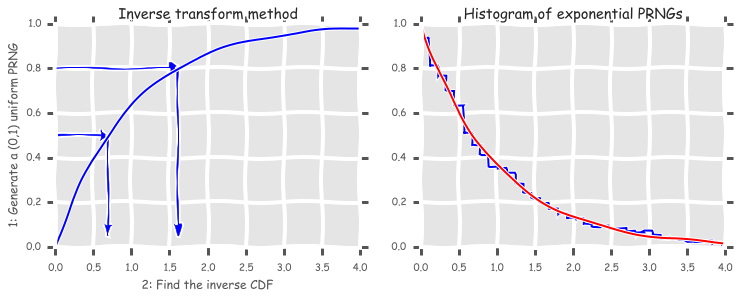

In [57]:
dist = stats.expon()
x = np.linspace(0,4,100)
y = np.linspace(0,1,100)

with plt.xkcd():
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(x, expon_cdf(x))
    plt.axis([0, 4, 0, 1])
    for q in [0.5, 0.8]:
        plt.arrow(0, q, expon_icdf(q)-0.1, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
        plt.arrow(expon_icdf(q), q, 0, -q+0.1, head_width=0.1, head_length=0.05, fc='b', ec='b')
    plt.ylabel('1: Generate a (0,1) uniform PRNG')
    plt.xlabel('2: Find the inverse CDF')
    plt.title('Inverse transform method');

    plt.subplot(122)
    u = np.random.random(10000)
    v = expon_icdf(u)
    plt.hist(v, histtype='step', bins=100, normed=True, linewidth=2)
    plt.plot(x, expon_pdf(x), linewidth=2)
    plt.axis([0,4,0,1])
    plt.title('Histogram of exponential PRNGs');

#### Creating a random number generator for arbitrary distributions

Suppose we have some random samples with an unknown distribtuion. We can still use the inverse transform method to create a random number generator from a random sample, by estimating the inverse CDF function using interpolation.

In [62]:
from scipy.interpolate import interp1d

def extrap1d(interpolator):
    """From StackOverflow http://bit.ly/1BjyRfk"""
    xs = interpolator.x
    ys = interpolator.y

    def pointwise(x):
        if x < xs[0]:
            return ys[0]+(x-xs[0])*(ys[1]-ys[0])/(xs[1]-xs[0])
        elif x > xs[-1]:
            return ys[-1]+(x-xs[-1])*(ys[-1]-ys[-2])/(xs[-1]-xs[-2])
        else:
            return interpolator(x)

    def ufunclike(xs):
        return np.array(map(pointwise, np.array(xs)))

    return ufunclike

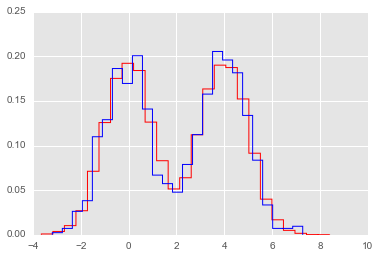

In [63]:
from statsmodels.distributions.empirical_distribution import ECDF

# Make up some random data
x = np.concatenate([np.random.normal(0, 1, 10000), 
                    np.random.normal(4, 1, 10000)])

ecdf = ECDF(x)
inv_cdf = extrap1d(interp1d(ecdf.y, ecdf.x, 
                            bounds_error=False, assume_sorted=True))
r = np.random.uniform(0, 1, 1000)
ys = inv_cdf(r)

plt.hist(x, 25, histtype='step', color='red', normed=True, linewidth=1)
plt.hist(ys, 25, histtype='step', color='blue', normed=True, linewidth=1);

#### Rejection sampling (Accept-reject method)

In [ ]:
# Suppose we want to sample from the (truncated) T distribution witb 10 degrees of freedom
# We use the uniform as a proposal distibution (highly inefficient)

x = np.linspace(-4, 4)

df = 10
dist = stats.cauchy()
upper = dist.pdf(0)

with plt.xkcd():
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(x, dist.pdf(x))
    plt.axhline(upper, color='grey')
    px = 1.0
    plt.arrow(px,0,0,dist.pdf(1.0)-0.01, linewidth=1,
              head_width=0.2, head_length=0.01, fc='g', ec='g')
    plt.arrow(px,upper,0,-(upper-dist.pdf(px)-0.01), linewidth=1, 
              head_width=0.3, head_length=0.01, fc='r', ec='r')
    plt.text(px+.25, 0.2, 'Reject', fontsize=16)
    plt.text(px+.25, 0.01, 'Accept', fontsize=16)
    plt.axis([-4,4,0,0.4])
    plt.title('Rejection sampling concepts', fontsize=20)

    plt.subplot(122)
    n = 100000
    # generate from sampling distribution
    u = np.random.uniform(-4, 4, n)
    # accept-reject criterion for each point in sampling distribution
    r = np.random.uniform(0, upper, n)
    # accepted points will come from target (Cauchy) distribution
    v = u[r < dist.pdf(u)]

    plt.plot(x, dist.pdf(x), linewidth=2)

    # Plot scaled histogram 
    factor = dist.cdf(4) - dist.cdf(-4)
    hist, bin_edges = np.histogram(v, bins=100, normed=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
    plt.step(bin_centers, factor*hist, linewidth=2)

    plt.axis([-4,4,0,0.4])
    plt.title('Histogram of accepted samples', fontsize=20);

#### Mixture representations

Sometimee, the targdt distribution from which we need to generate random numbers can be expressed as a mixture of "simpler" distributions that we already know how to sample from

$$
f(x) = \int{g(x\,|\,y)p(y) dy}
$$

For example, if $y$ is drawn from the $\chi_\nu^2$ distrbution, then $\mathcal{N}(0, \nu/y)$ is a sample from the Student's T distribution with $\nu$ degrees fo freedom.

In [ ]:
n = 10000
df = 5
dist = stats.t(df=df)
y = stats.chi2(df=df).rvs(n)
r = stats.norm(0, df/y).rvs(n)

with plt.xkcd():
    plt.plot(x, dist.pdf(x), linewidth=2)

    # Plot scaled histogram 
    factor = dist.cdf(4) - dist.cdf(-4)
    hist, bin_edges = np.histogram(v, bins=100, normed=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
    plt.step(bin_centers, factor*hist, linewidth=2)

    plt.axis([-4,4,0,0.4])
    plt.title('Histogram of accepted samples', fontsize=20);

#### Ad-hoc methods - e.g. Box-Muller for generating normally distributed random numbers

The Box-Muller transform starts wtih 2 random uniform numbers $u$ and $v$
- Generate an exponentailly distributed variable $r^2$ from $u$ using the inverse transform method
- This means that $r$ is an exponentially distributed variable on $(0, \infty)$
- Generate a variable $\theta$ unformly distributed on $(0, 2\pi)$ from $v$ by scaling
- In polar coordinates, the vector $(r, \theta)$ has an indepdendent bivariate normal distribution
- Hence the projection onto the $x$ and $y$ axes give independent univarate normal random numbers

Note:

- Normal random numbers can also be generated using the *general* inverse transform method (e.g. by approximating the inverse CDF with a polynomial) or the rejection method (e.g. using the exponential distribution as the sampling distribution). 
- There is also a variant of Box-Muller that does not require the use of (expensive) trigonometric calculations.

In [ ]:
n = 1000
u1 = np.random.random(n)
u2 = np.random.random(n)
r_squared = -2*np.log(u1)
r = np.sqrt(r_squared)
theta = 2*np.pi*u2
x = r*np.cos(theta)
y = r*np.sin(theta)

In [ ]:
sns.jointplot(x, y, kind='scatter');

### Using a random number generator

From this part onwards, we will assume that there is a library of PRNGs that we can use - either from numpy.random or scipy.stats which are both based on the Mersenne Twister, a high-quality PRNG for random integers. The numpy versions simply generate ranodm deviates while the scipy versions will also provide useful functions related to the distribution, e.g. PDF, CDF and quantiles.

In [ ]:
# Using numpy
import numpy.random as npr

rs = npr.beta(a=0.5, b=0.5, size=1000)
plt.hist(rs, bins=20, histtype='step', normed=True, linewidth=1);

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R

n <- 5
xs <- c(0.1, 0.5, 0.9)
print(dbeta(xs, 0.5, 0.5))
print(pbeta(xs, 0.5, 0.5))
print(qbeta(xs, 0.5, 0.5))
print(rbeta(n, 0.5, 0.5))

In [ ]:
# Using scipy
import scipy.stats as ss

n = 5
xs = [0.1, 0.5, 0.9]
rv = ss.beta(a=0.5, b=0.5)

print rv.pdf(xs) # equivalent of dbeta
print rv.cdf(xs) # equivalent of pbeta
print rv.ppf(xs) # equvialent of qbeta
print rv.rvs(n) # equivalent of rbeta

In [ ]:
# And here is a plot of the PDF for the beta distribution
xs = np.linspace(0, 1, 100)
plt.plot(xs, ss.beta.pdf(xs, a=0.5, b=0.5));

### Monte Carlo integration

The basic idea of Monte Carlo integration is very simple and only requires elemenatry statistics. Suppose we want to find the value of 
$$
\int_a^b f(x) dx
$$
in some region with volumne $V$. Monte Carlo integration estimates this integral by estimaing the fraction of random points that fall below $f(x)$ multiplied by $V$. 


In a statistical context, we use Monte Carlo integration to estimate the expectation
$$
E[h(X)] = \int_X h(x) f(x) dx
$$

with

$$
\bar{h_n} = \frac{1}{n} \sum_{i=1}^n h(x_i)
$$
where $x_i \sim f$ is a draw from the density $f$.

We can estimate the Monte Carlo variance of the approximation as
$$
v_n = \frac{1}{n^2} \sum_{o=1}^n (h(x_i) - \bar{h_n})^2)
$$

Also, from the Central Limit Theorem,

$$
\frac{\bar{h_n} - E[h(X)]}{\sqrt{v_n}} \sim \mathcal{N}(0, 1)
$$

The convergence of Monte Carlo integration is $\mathcal{0}(n^{1/2})$ and independent of the dimensionality. Hence Monte Carlo integration gnereally beats numerical intergration for moderate- and high-dimensional integration since numerical integration (quadrature) converges as $\mathcal{0}(n^{d})$. Even for low dimensional problems, Monte Carlo integration may have an advantage when the volume to be integrated is concentrated in a very small region and we can use information from the distribution to draw samples more often in the region of importance.

### Example

We want to estiamte the following integral $\int_0^1 e^x dx$. The minimum value of the function is 1 at $x=0$ and $e$ at $x=1$.

In [ ]:
x = np.linspace(0, 1, 100)
plt.plot(x, np.exp(x));
pts = np.random.uniform(0,1,(100, 2))
pts[:, 1] *= np.e
plt.scatter(pts[:, 0], pts[:, 1])
plt.xlim([0,1])
plt.ylim([0, np.e]);

In [ ]:
# Check analytic solution

from sympy import symbols, integrate, exp

x = symbols('x')
expr = integrate(exp(x), (x,0,1))
expr.evalf()

In [ ]:
# Using numerical quadrature
# You may recall elementary versions such as the 
# trapezoidal and Simpson's rules
# Note that nuerical quadrature needs $n^p$ grid points
# in $p$ dimensions to maintain the same accuracy
# This is known as the curse of dimensionality and explains
# why quadrature is not used for high-dimensional integration

from scipy import integrate
integrate.quad(exp, 0, 1)

In [ ]:
# Monte Carlo approximation

for n in 10**np.array([1,2,3,4,5,6,7,8]):
    pts = np.random.uniform(0, 1, (n, 2))
    pts[:, 1] *= np.e
    count = np.sum(pts[:, 1] < np.exp(pts[:, 0]))
    volume = np.e * 1 # volume of region
    sol = (volume * count)/n
    print '%10d %.6f' % (n, sol)

### Montioring variance

We are often interested in knowning how many iterations it takes for Monte Carlo integration to "converge". To do this, we would like some estimate of the variance, and it is useful to inspect such plots. One simple way to get confidence intervals for the plot of Monte Carlo estimate against number of interations is simply to do many such simulations.

For the example, we willl try to etsimate the function

$$
f(x) = x \cos 7x + \sin 13x, \ \  0 \le x \le 1
$$

In [ ]:
def f(x):
    return x * np.cos(71*x) + np.sin(13*x)

In [ ]:
x = np.linspace(0, 1, 100)
plt.plot(x, f(x));

#### Exact solution

In [ ]:
from sympy import sin, cos, symbols, integrate

x = symbols('x')
integrate(x * cos(71*x) + sin(13*x), (x, 0,1)).evalf(6)

#### Using multiple independent sequences

In [ ]:
n = 100
reps = 1000

In [ ]:
x = f(np.random.random((n, reps)))
y = 1/np.arange(1, n+1)[:, None] * np.cumsum(x, axis=0)
upper, lower = np.percentile(y, [2.5, 97.5], axis=1)

In [ ]:
plt.plot(np.arange(1, n+1), y, c='grey', alpha=0.02)
plt.plot(np.arange(1, n+1), y[:, 0], c='red', linewidth=1);
plt.plot(np.arange(1, n+1), upper, 'b', np.arange(1, n+1), lower, 'b');

#### Using bootstrap

In [ ]:
xb = np.random.choice(x[:,0], (n, reps), replace=True)
yb = 1/np.arange(1, n+1)[:, None] * np.cumsum(xb, axis=0)
upper, lower = np.percentile(yb, [2.5, 97.5], axis=1)

In [ ]:
plt.plot(np.arange(1, n+1)[:, None], yb, c='grey', alpha=0.02)
plt.plot(np.arange(1, n+1), yb[:, 0], c='red', linewidth=1)
plt.plot(np.arange(1, n+1), upper, 'b', np.arange(1, n+1), lower, 'b');

## Monte Carlo swindles (Variance reduction techniques)

There are several general techiques for variance reduction, someitmes known as Monte Carlo swindles since these metthods improve the accuracy and convergene rate of Monte Carlo integration without increasing the number of Monte Carlo samples. Some Monte Carlo swindles are:

- importance sampling
- stratified sampling
- control variates
- antithetic variates
- conditioning swindles including Rao-Blackwellization and independent variance decomposition

Most of these techniques are not particularly computational in nature, so we will not cover them in the course. I expect you will learn them elsewhere. Indepedence sampling will be shown as an example of a Monte Carlo swindle.

### Variance reduction by change of variables

The Cauchy distribution is given by 
$$
f(x) = \frac{1}{\pi (1 + x^2)}, \ \ -\infty < x < \infty 
$$

Suppose we want to integrate the tail probability $P(X > 3)$ using Monte Carlo

In [ ]:
h_true = 1 - stats.cauchy().cdf(3)
h_true

#### Direct Monte Carlo integration is inefficient since only 10% of the samples give inforrmation about the tail

In [ ]:
n = 100

x = stats.cauchy().rvs(n)
h_mc = 1.0/n * np.sum(x > 3)
h_mc, np.abs(h_mc - h_true)/h_true

We are trying to estimate the quantity

$$
\int_3^\infty \frac{1}{\pi (1 + x^2)} dx
$$

Using the substitution $y = 3/x$ (and a little algebra), we get

$$
\int_0^1 \frac{3}{\pi(9 + y^2)} dy
$$

Hence, a much more efficient MC estimator is 

$$
\frac{1}{n} \sum_{i=1}^n \frac{3}{\pi(9 + y_i^2)}
$$

where $y_i \sim \mathcal{U}(0, 1)$.

In [ ]:
y = stats.uniform().rvs(n)
h_cv = 1.0/n * np.sum(3.0/(np.pi * (9 + y**2)))
h_cv, np.abs(h_cv - h_true)/h_true

### Importance sampling

Basic Monte Carlo sampling evaluates

$$
E[h(X)] = \int_X h(x) f(x) dx
$$

Using another distribution $g(x)$ - the so-called "importance function", we can rewrite the above expression

$$
E_f[h(x)] \ = \  \int_X h(x) \frac{f(x)}{g(x)} g(x) dx \ = \ E_g\left[ \frac{h(X) f(X)}{g(X)} \right]
$$

giving us the new estimator

$$
\bar{h_n} = \frac{1}{n} \sum_{i=1}^n \frac{f(x_i)}{g(x_i)} h(x_i)
$$

where $x_i \sim g$ is a draw from the density $g$.

Conceptually, what the likelihood ratio $f(x_i)/g(x_i)$ provides an indicator of how "important" the sample $h(x_i)$ is for estmating $\bar{h_n}$. This is very dependent on a good choice for the importance function $g$. Two simple choices for $g$ are scaling

$$
g(x) = \frac{1}{a} f(x/a)
$$

and translation

$$
g(x) = f(x - a)
$$

Alternatlvely, a different distribtuion can be chosen as shown in the example below.

#### Example

Suppose we want to estimate the tail probability of $\mathcal{N}(0, 1)$ for $P(X > 5)$. Regular MC integration using samples from $\mathcal{N}(0, 1)$ is hopeless since nearly all samples will be rejected. However, we can use the exponential density truncated at 5 as the importance function and use importance sampling.

In [ ]:
x = np.linspace(4, 10, 100)
plt.plot(x, stats.expon(5).pdf(x))
plt.plot(x, stats.norm().pdf(x));

#### Expected answer

We expect about 3 draws out of 10,000,000 from $\mathcal{N}(0, 1)$ to have a value greater than 5. Hence simply sampling from $\mathcal{N}(0, 1)$ is hopelessly inefficient for Monte Carlo integration.

In [ ]:
%precision 10

In [ ]:
h_true =1 - stats.norm().cdf(5)
h_true

#### Using direct Monte Carlo integration

In [ ]:
n = 10000
y = stats.norm().rvs(n)
h_mc = 1.0/n * np.sum(y > 5)
# estimate and relative error
h_mc, np.abs(h_mc - h_true)/h_true 

#### Using importance sampling

In [ ]:
n = 10000
y = stats.expon(loc=5).rvs(n)
h_is = 1.0/n * np.sum(stats.norm().pdf(y)/stats.expon(loc=5).pdf(y))
# estimate and relative error
h_is, np.abs(h_is- h_true)/h_true

## Quasi-random numbers

Recall that the convergence of Monte Carlo integration is $\mathcal{0}(n^{1/2})$. It turns out that if we use quasi-random or low discrepancy sequences (which fill space more efficiently than random sequences), we can get convergence approaching $\mathcal{0}(1/n)$. There are several such generators, but their use in statistical settings is limited to cases where we are intergrating with respect to uniform distributions. The regularity can also give rise to errors when estimating integrals of periodic functions.

In [ ]:
! pip install ghalton &> /dev/null

In [ ]:
import ghalton

gen2 = ghalton.Halton(2)

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
xs = np.random.random((100,2))
plt.scatter(xs[:, 0], xs[:,1])
plt.axis([-0.05, 1.05, -0.05, 1.05])
plt.title('Pseudo-random', fontsize=20)
plt.subplot(122)
ys = np.array(gen.get(100))
plt.scatter(ys[:, 0], ys[:,1])
plt.axis([-0.05, 1.05, -0.05, 1.05])
plt.title('Quasi-random', fontsize=20);

### Quasi-Monte Carlo integration can reduce variance

In [ ]:
% precision 4

In [ ]:
h_true = 1 - stats.cauchy().cdf(3)

In [ ]:
n = 10

In [ ]:
x = stats.uniform().rvs((n, 5))
y = 3.0/(np.pi * (9 + x**2))
h_mc = np.sum(y, 0)/n
zip(h_mc, 100*np.abs(h_mc - h_true)/h_true)

In [ ]:
gen1 = ghalton.Halton(1)
x = np.reshape(gen1.get(n*5), (n, 5))
y = 3.0/(np.pi * (9 + x**2))
h_qmc = np.sum(y, 0)/n
zip(h_qmc, 100*np.abs(h_qmc - h_true)/h_true)